In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report # 这个包是评估报告

# 1. Multi-class Classification

In [2]:
def load_data(path, transpose = True):
    data = sio.loadmat(path)
    y = data.get('y') # (5000, 1)
    y = y.reshape(y.shape[0])
    
    X = data.get('X') # (5000, 400)
    
    if transpose:
        X = np.array([im.reshape(20, 20).T for im in X])
        X = np.array([im.reshape(400) for im in X])
    return X, y

In [3]:
X, y = load_data('ex3data1.mat', True)
print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [4]:
def plot_an_image(image):
    fig, ax = plt.subplots(figsize = (1,1))
    ax.matshow(image.reshape(20,20), cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

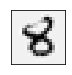

This digital is 8.


In [5]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one]) # pick one figure and show it
print('This digital is {}.'.format(y[pick_one]))

In [6]:
def plot_100_images(X):
    size = int(np.sqrt(X.shape[1]))
    sample_rows = np.random.choice(np.arange(X.shape[0]), 100)
    sample_images = X[sample_rows, :]
    fig, ax = plt.subplots(nrows = 10, ncols = 10, sharex = True, sharey = True, figsize = (8, 8))
    for r in range(10):
        for c in range(10):
            ax[r][c].matshow(sample_images[r*10+c].reshape(size,size), cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

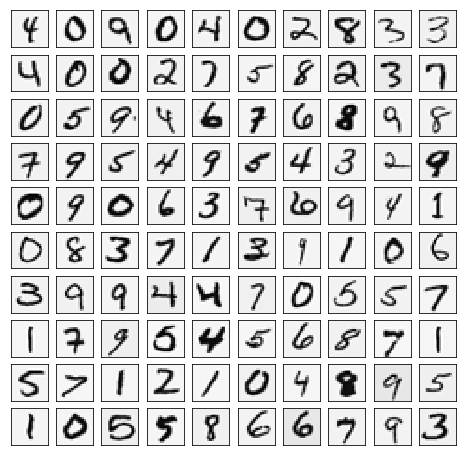

In [7]:
plot_100_images(X)

In [8]:
raw_X, raw_y = load_data('ex3data1.mat')
print(raw_X.shape)
print(raw_y.shape)

(5000, 400)
(5000,)


# 准备数据

In [9]:
X = np.insert(raw_X, 0, values = np.ones(X.shape[0]), axis = 1) # 将全一的列向量插入了第一列
X.shape

(5000, 401)

In [10]:
y_matrix = []
for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))
y_matrix = [y_matrix[-1]] + y_matrix[:-1] # 注意：加号前边的一项是[y_matrix[-1]]，是带中括号的
y = np.array(y_matrix)
y.shape

(10, 5000)

In [11]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

# train 1 model（训练一维模型）

In [12]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

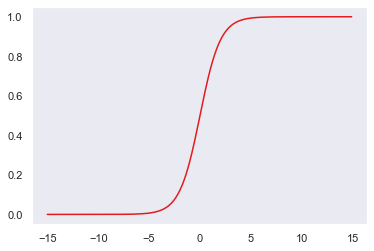

In [13]:
sns.set(style = 'dark', palette = 'Set1')
plt.plot(np.arange(-15, 15, 0.1), sigmoid(np.arange(-15, 15, 0.1)))
plt.show()

In [14]:
def cost(theta, X, y):
    cost_list = -y*np.log(sigmoid(X@theta))-(1-y)*np.log(1-sigmoid(X@theta))
    return cost_list.sum()/len(X)

In [15]:
def regularized_cost(theta, X, y, lam = 1):
    regularized_term = np.power(theta[1:], 2).sum()*lam/(2*len(X))
    return cost(theta, X, y) + regularized_term

In [16]:
def gradient(theta, X, y):
    return ((sigmoid(X@theta) - y)@X)/len(X)

In [17]:
def regularized_gradient(theta, X, y, lam = 1):
    regularized_term = np.concatenate((np.array([0]), theta[1:]*lam/len(X)))
    return gradient(theta, X, y) + regularized_term

In [18]:
def logistic_regression(X, y, lam = 1):
    theta = np.zeros(X.shape[1])
    # result = opt.minimize(fun = regularized_cost, x0 = theta, args = (X, y, lam),
    #                       method = 'TNC', jac = regularized_gradient, options = {'disp': True})
    result = opt.minimize(fun = regularized_cost, x0 = theta, args = (X, y, lam),
                         method = 'TNC', jac = regularized_gradient)
    return result.x

In [19]:
def predict(x, optimized_theta):
    prob = sigmoid(x@optimized_theta)
    return (prob >= 0.5).astype(int)

In [20]:
t0 = logistic_regression(X, y[0])

In [21]:
print(t0.shape)
y_pred = predict(X, t0)
print('Accuracy = {}'.format(np.mean(y[0] == y_pred)))

(401,)
Accuracy = 0.9974


# train k model（训练k维模型）

In [22]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])
k_theta.shape

(10, 401)

# 进行预测

* think about the shape of k_theta, now you are making $X\times\theta^T$ \
$(5000, 401)\times(10, 401).T = (5000, 10)$
* after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer


In [23]:
prob_matrix = sigmoid(X@k_theta.T)
prob_matrix.shape

(5000, 10)

In [24]:
np.set_printoptions(edgeitems = 3, linewidth = 100, suppress = True)
prob_matrix

array([[0.99577398, 0.        , 0.00053532, ..., 0.00006466, 0.00003906, 0.0017218 ],
       [0.99834663, 0.0000001 , 0.00005613, ..., 0.00009695, 0.0000029 , 0.00008489],
       [0.99139952, 0.        , 0.00056832, ..., 0.00000655, 0.0265387 , 0.00197397],
       ...,
       [0.00000068, 0.04141995, 0.00321088, ..., 0.00012707, 0.00297314, 0.70754701],
       [0.00001843, 0.00000013, 0.00000009, ..., 0.0016468 , 0.0682376 , 0.86108748],
       [0.02880781, 0.        , 0.0001297 , ..., 0.36628776, 0.00497232, 0.14829824]])

In [25]:
y_pred = np.argmax(prob_matrix, axis = 1) # 返回沿轴axis最大值的索引，axis = 1 代表行

In [26]:
y_pred

array([0, 0, 0, ..., 9, 9, 7])

In [27]:
y_answer = raw_y.copy()
y_answer[y_answer == 10] = 0

In [28]:
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 神经网络模型图示

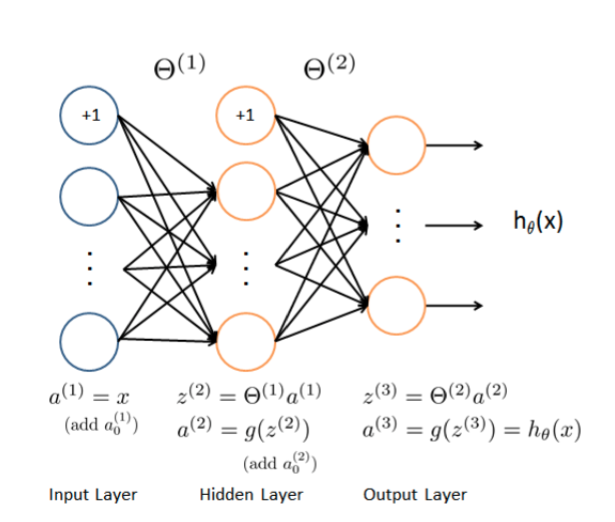

In [29]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [30]:
theta1, theta2 = load_weight('ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。所以为了应用给定的参数，我需要使用原始数据（不转置）

In [31]:
X, y = load_data('ex3data1.mat', transpose = False)
X = np.insert(X, 0, np.ones(X.shape[0]), axis = 1) # intercept
X.shape, y.shape

((5000, 401), (5000,))

# feed forward prediction（前馈预测）

In [32]:
a1 = X

In [33]:
z2 = a1@theta1.T
z2.shape

(5000, 25)

In [34]:
z2 = np.insert(z2, 0, np.ones(z2.shape[0]), axis = 1)
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [35]:
z3 = a2@theta2.T
z3.shape

(5000, 10)

In [36]:
a3 = sigmoid(z3)
a3

array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326, 0.99622946],
       [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617, 0.99619667],
       [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 , 0.93586278],
       ...,
       [0.06278247, 0.00450406, 0.03545109, ..., 0.0026367 , 0.68944816, 0.00002744],
       [0.00101909, 0.00073436, 0.00037856, ..., 0.01456166, 0.97598976, 0.00023337],
       [0.00005908, 0.00054172, 0.0000259 , ..., 0.00700508, 0.73281465, 0.09166961]])

In [37]:
y_pred = np.argmax(a3, axis = 1) + 1 # numpy is 0 base index, +1 for matlab convention，其实就是为了下边与给定的y做对比输出报告
y_pred.shape

(5000,)

In [38]:
from collections import Counter
Counter(y_pred)

Counter({10: 505,
         8: 502,
         9: 497,
         4: 499,
         6: 507,
         1: 508,
         3: 491,
         7: 495,
         2: 493,
         5: 503})

# 准确率
虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。

In [39]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

